# Conservative tracer experiments

In [1]:
from os import system
import pickle

## PFLOTRAN
import jupypft.model as mo
import jupypft.parameter as pm
import jupypft.plotBTC as plotBTC

def resetPickle():
    mo.Model.resetListOfModels()
    global caseDict
    with open('caseDict.pkl', 'rb') as f:
        caseDict = pickle.load(f)
    
    pm.Parameter.rebuildListOfObjects(caseDict)
    
    global listOfAllParameters
    listOfAllParameters = pm.Parameter.list_of_vars()
    
    system("rm -rf CASE*")
    
def plotResults():
    system("rm -rf MASSBALANCES; mkdir MASSBALANCES")
    system("cp ./CASE**/*-mas.dat ./MASSBALANCES")
    mo.Model.folderFixedToCSV("MASSBALANCES")

    waterDensity = 999.65
    m3ToL = 1000.

    plotBTC.plotMassBalancesInFolder(
        folderToPlot="MASSBALANCES",
        indices = {'t':"Time [d]",\
                   'q':"ExtractWell Water Mass [kg/d]",\
                   'm':"ExtractWell Vaq [mol/d]"},
        normalizeWith={'t':1.0,'q':waterDensity/m3ToL,'m':1.0},
        legendTitle = legendTitle)
    
def buildSim(caseName):
    ## Create a folder for the case
    currentFolder = "./CASE_{0}".format(caseName)
    currentFile = currentFolder + "/" + caseName +".in"
    system("mkdir " + currentFolder)
    
    ## Initialize PFLOTRAN model
    BoxModel = mo.Model(
        templateFile = templateFile,
        runFile = currentFile,
        execPath = execPath,
        verbose=True
        )
       
    ## Copy template input file to folder
    BoxModel.cloneTemplate()
    
    ## Replace tags for values in case
    for parameter in listOfAllParameters:
        BoxModel.replaceTagInFile(parameter)

    return BoxModel

## Dummy for caseDict
caseDict = {}

First, let's build the directory of the templates that are available to be used here:

In [2]:
def getTemplate(key):
    templateFiles = {\
         "Open"   : "tpl_Richards_3Dbox_conservative_openBounds.in",
         "Sides"  : "tpl_Richards_3Dbox_conservative_2closedBounds.in",
         "Closed" : "tpl_Richards_3Dbox_conservative_3closedBounds.in"
        }
    
    templateFolder = "../TEMPLATES/boxes_3D/"
    return templateFolder + templateFiles[key]

templateFile = getTemplate("Sides")

## Path to the pflotran executable
execPath = "$PFLOTRAN_DIR/buildExperimental/pflotran"


## 1.1 Varying the extraction well screen length

<img src="../SKETCHES/ScreenLength.png" alt="Varying the well screen lenghy" width="800" height="100">

The first case studied here has to do with the screen length of the extraction well, i.e., the actual portion of the well that pulls the aquifer's water. The following escenarios are set-up such as the the screen lenght spans:

1. the aquifer depth completely
2. only top half of the aquifer depth 
3. only the bottom half of the aquifer depth 

Notice for a constant extraction rate, escenarios 2 and 3 will induce higher Darcy velocities because less area on the well is available for the same volume of water to be extracted. 

**Result:** Escenario 2 is the worst case because the top half open configuration represents the shortest travel distance between injection and extraction. This case is common after the failure of a well that starts drawing water from a soil it was not supposed to. 
.

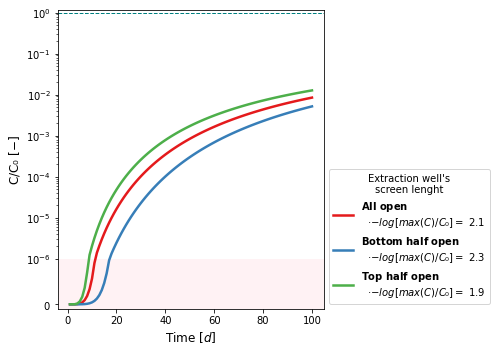

In [3]:
resetPickle()
caseDict['Q']['Out'].value = -100.
caseDict['Q']['In'].value = 10.

#Define escenarios
caseDict['outCoord']['Z'][1].value = 1.0
caseDict['outCoord']['Z'][2].value = caseDict['L']['Z'].value - 1.0
buildSim("All_open")

caseDict['outCoord']['Z'][1].value = caseDict['L']['Z'].value / 2.0
caseDict['outCoord']['Z'][2].value = caseDict['L']['Z'].value - 1.0
buildSim("Top_half_open")

caseDict['outCoord']['Z'][1].value = 1.0
caseDict['outCoord']['Z'][2].value = caseDict['L']['Z'].value / 2.0
buildSim("Bottom_half_open")

#Run Models and show results
mo.Model.runAllModels(nProcs=3)
legendTitle = "Extraction well's\nscreen lenght"
plotResults()

## 1.2 Varying the boundary conditions at the sides

<img src="../SKETCHES/ClosedBoundaries.png" alt="Varying the boundary conditions" width="800" height="100">

In this case, we'll look at the effect of having some no-flow boundary conditions in our domain.

1. All side boundaries allow the inflow of clean water.
2. The two side boundaries that are parallel to the injection-extraction line do not allow flow.
3. The two side boundaries that are parallel to the injection-extraction line and the one opposite to the injection point do not allow flow.

**Result:** Escenario 3 is the worst case but it is uncommon to find such system. Escenario 2 seems like a better option to follow.

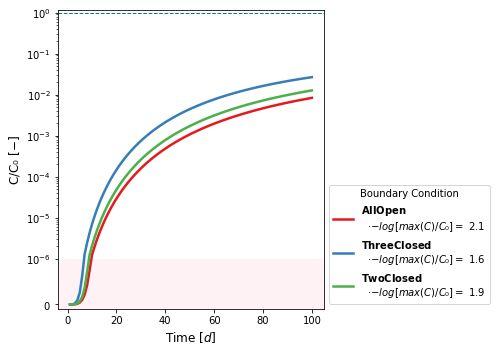

In [7]:
resetPickle()
caseDict['Q']['Out'].value = -100.
caseDict['Q']['In'].value = 10.

## Build escenarios
templateFile = getTemplate("Open")
buildSim("AllOpen")

templateFile = getTemplate("Closed")
buildSim("ThreeClosed")

templateFile = getTemplate("Sides")
buildSim("TwoClosed")

#Run and show results
mo.Model.runAllModels(nProcs=3)
legendTitle = "Boundary Condition"
plotResults()

## 1.3 Varying the porosity ($\theta$)

In this case, we want to test the effect of the aquifer porosity in the travel time of the contaminant. We are using constant extraction and injection rates, thus, the Darcy velocities ($q$) should not depend on this parameter. However, the pore-water velocity ($u = \tfrac{q}{\theta}$) will differ. 

**Result:** A lower porosity brings faster the contaminant. This sounds counterintuitive as a lower porosity is associated with more opposition for water to travel through the porous media, however, in these experiments we are setting constant extraction and injection rates. 

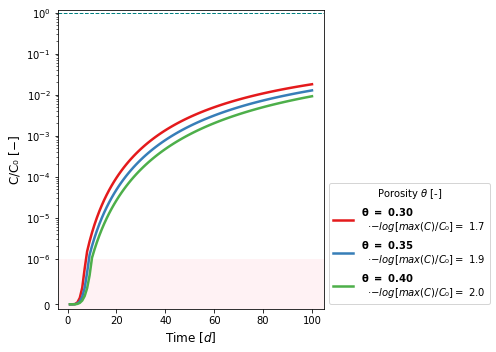

In [8]:
resetPickle()
caseDict['Q']['Out'].value = -100.
caseDict['Q']['In'].value = 10.

templateFile = getTemplate("Sides")

## Build escenarios
caseDict['theta'].value = 0.30
buildSim("θ_=_0.30")

caseDict['theta'].value = 0.35
buildSim("θ_=_0.35")

caseDict['theta'].value = 0.40
buildSim("θ_=_0.40")

#Run and show results
mo.Model.runAllModels(nProcs=4)
legendTitle = "Porosity $\\theta$ [-]"
plotResults()

## 1.4 Varying the extraction rate ($Q_{out}$)

The rate of extraction is a function of how many people is the well supposed to serve, if its purpose is to serve as drinking water source. The annual average water requirement for residential use varies between 284 and 490 LPCD (Liters per capita per day). In this sense, an extraction rate of 21m³/d could serve a small community of 50 people, while an extraction rate of 1000m³/d could serve about 2500 people.  

Notice that the injection rate $Q_{in}$ is kept constant. In these escenarios, flow in the aquifer is induced only by the extraction/injection pair, hence, all the mass of the injected contaminant is expected to reach the extraction point. In this sense, the maximum concentration that can be obtained in water drawn by the extraction well is the ratio $\frac{Q_{in}}{Q_{out}}$. 

**Result:** These simulations show that higher extraction rates end up in faster arrival times, however, higher dilution rates are obtained as well. Since no decay is considered here, all breakthrough curves will arrive at the maximum dilution ratio $\frac{Q_{in}}{Q_{out}}$, given enough time. However, given the survival time of the virus, a residence time of more that 100 days is high enough to trigger more that 6-log reduction just because of decay. 

Higher extraction rates are connected to more complex drinking water treatment systems, hence, desinfection processes are expected which can serve to reduce the risk associated to virus exposure. A low extraction well represents a small system that is more likely to lack a treatment system. 

In conclusion, low extraction rates can lead to higher outlet concentrations and can be associated to less controled systems in terms of water treatment. Even though in this example, they represent the slower residence time, it will be shown later that after a regional flow is imposed (which is more likely in a natural environment), the extraction rate becomes unimportant as the aquifer Darcy velocities. 

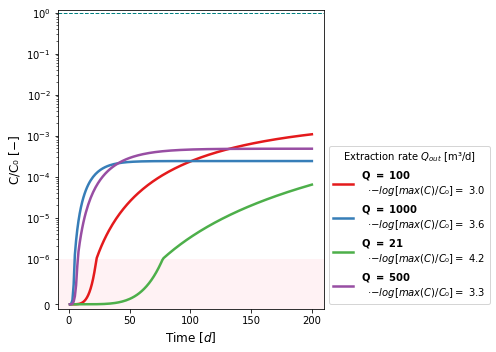

In [9]:
resetPickle()
caseDict['endTime'].value = 200.

## Build escenarios
caseDict['Q']['Out'].value = -21.
buildSim("Q_=_21")

caseDict['Q']['Out'].value = -100.
buildSim("Q_=_100")

caseDict['Q']['Out'].value = -500.
buildSim("Q_=_500")

caseDict['Q']['Out'].value = -1000.
buildSim("Q_=_1000")

#Run and show results
mo.Model.runAllModels(nProcs=4)
legendTitle = "Extraction rate $Q_{out}$ [m³/d]"
plotResults()

## 1.5 Varying the  leaking rate ($Q_{in}$)

<img src="../SKETCHES/LeakingPipe.png" alt="LeakingPipe" width="300" height="80">

How much raw wastewater can leave a failing sewage line or septic tank will depend on the degree of damage of the system and the soil permeability. This could be represented with the depth of the flow in the leaking pipe and a characteristic permeability (or a conductance) associated to the status of the pipe walls. For the sake of simplicity, a constant leaking rate is assumed in these experiments, i.e., invariant to the soil properties. 

**Result**: As expected, a higher leaking rate results in a faster breakthrough curve. However, these effects will be dwarfed by the presence of a regional flow.

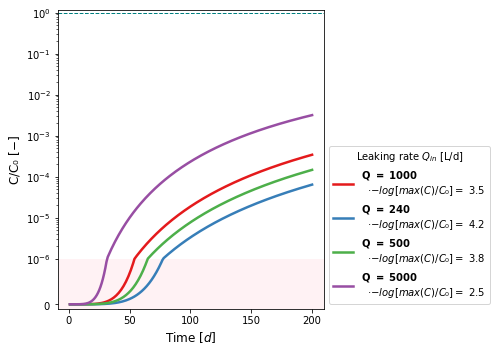

In [11]:
resetPickle()
caseDict['endTime'].value = 200.

## Build escenarios
caseDict['Q']['In'].value = 0.24
buildSim("Q_=_240")

caseDict['Q']['In'].value = 0.50
buildSim("Q_=_500")

caseDict['Q']['In'].value = 1.0
buildSim("Q_=_1000")

caseDict['Q']['In'].value = 5.0
buildSim("Q_=_5000")

#Run and show results
mo.Model.runAllModels(nProcs=4)
legendTitle = "Leaking rate $Q_{in}$ [L/d]"
plotResults()

## 1.6 Varying the setback distance ($r$)

<img src="../SKETCHES/SetbackDistance.png" alt="Varying the boundary conditions" width="400" height="40">

The effect of how far the injection point is from the extraction well is evaluated here.

**Result:** The closer the leaking point is to the extraction well, the lower the residence time, so the contaminant will reach the extraction well faster. Close contamination sources to water extraction points are less likely as extraction must be done at least some distance away from sewage lines or septic tanks, acordinh to local regulations. For this reason, a setback distance of 40m will be kept. 

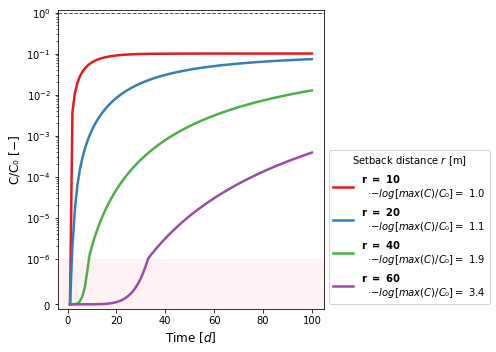

In [10]:
resetPickle()
caseDict['Q']['Out'].value = -100.
caseDict['Q']['In'].value = 10.

## Build escenarios
outX = caseDict['outCoord']['X'][1].value

caseDict['inCoord']['X'][1].value = outX + 10
buildSim("r_=_10")

caseDict['inCoord']['X'][1].value = outX + 20
buildSim("r_=_20")

caseDict['inCoord']['X'][1].value = outX + 40
buildSim("r_=_40")

caseDict['inCoord']['X'][1].value = outX + 60
buildSim("r_=_60")

#Run and show results
mo.Model.runAllModels(nProcs=4)
legendTitle = "Setback distance $r$ [m]"
plotResults()

## 1.7 Water table gradient

To this point, all the simulations have been performed under the assumption that there is no regional flow in the system, meaning that the water in the aquifer only moves obeying the leaking/extraction points. We previously saw that low extraction rates lead to low potential dilutions, so that should be a worst case scenario if the contaminant could reach the well in a short period of time. That can happen if the flow in the system is governed by a water table gradient, which is the usual driver of groundwater flow. A high gradient will represent a faster flow in the aquifer, however, it will bring more dilution as not all the mass injected in the system has to end up extracted by the well. A sharp gradient can have the effect of making the contaminant plume pass the well faster than it draws water from the system. 

**Results:** High water table gradients can indeed shorten the time it takes a contaminant to reach the extraction well. However, if this gradient gets too high, a dilution effect begins to be noticeable. The worst escenario for this particular set up is found around 5×10⁻⁵ m/m. 

### 1.7.1 Various orders of magnitude

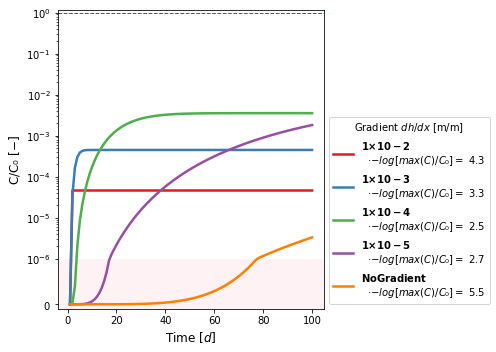

In [6]:
resetPickle()

## Build escenarios
caseDict['Gradient']['X'].value = 0.0
buildSim("NoGradient")

caseDict['Gradient']['X'].value = 1.0E-5
buildSim("1×10-5")

caseDict['Gradient']['X'].value = 1.0E-4
buildSim("1×10-4")

caseDict['Gradient']['X'].value = 1.0E-3
buildSim("1×10-3")

caseDict['Gradient']['X'].value = 1.0E-2
buildSim("1×10-2")

# Run and Plot
mo.Model.runAllModels(nProcs=5)
legendTitle = "Gradient $dh/dx$ [m/m]"
plotResults()

### 1.7.2 Narrow down to find the worst case

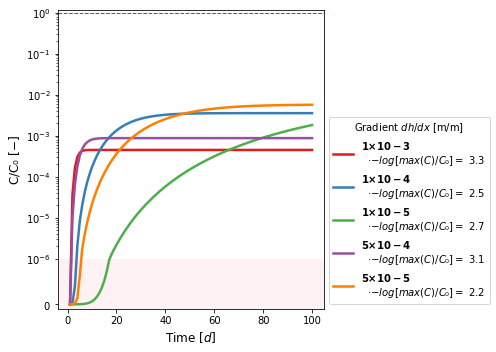

In [14]:
resetPickle()

## Build escenarios
caseDict['Gradient']['X'].value = 1.0E-5
buildSim("1×10-5")

caseDict['Gradient']['X'].value = 5.0E-5
buildSim("5×10-5")

caseDict['Gradient']['X'].value = 1.0E-4
buildSim("1×10-4")

caseDict['Gradient']['X'].value = 5.0E-4
buildSim("5×10-4")

caseDict['Gradient']['X'].value = 1.0E-3
buildSim("1×10-3")

# Run and Plot
mo.Model.runAllModels(nProcs=6)
legendTitle = "Gradient $dh/dx$ [m/m]"
plotResults()

## 1.8 Varying the reference temperature

Darcy's law states that the flow velocity $q$ in a porous media is proportional to the hydraulic gradient $\partial h/\partial x$ and the hydraulic conductivity $K$.

\begin{equation}
    q = -K \dfrac{\partial h}{\partial x}
\end{equation}

The hydraulic conductivity $K$ [m/s] depends on both fluid and solid matrix properties, following the expression $K = k/\mu$, where $\mu$ is the water dynamic viscosity and the soil permeability $k$. The former changes with temperature, a warmer environment leads to less viscous water, thus, a higher hydraulic conductivity.

In these experiments, the effect on the breakthrough curves of different reference temperatures is calculated. At this point, the tracer is still treated as conservative, but latter a decay rate dependant on the temperature of the water in the system will be introduced.

**Result:** As expected, a warmer system brings the contaminant faster to the extraction point because the hydraulic conductivity is increased. But this also means that a higher dilution is obtained, thus, a lower end concentration is obtained in the well. Nvertheless, the effect of temperature in hydrodynamics is negligible, it will be much more important when considering reactive transport. 


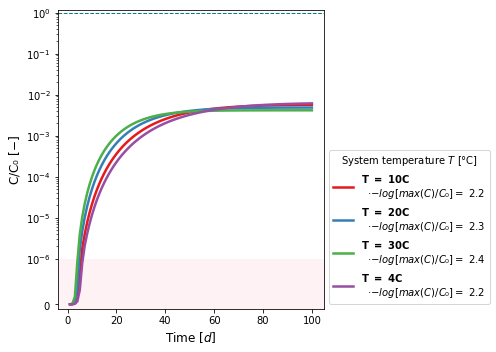

In [12]:
resetPickle()
caseDict['endTime'].value = 100.
caseDict['Gradient']['X'].value = 5.0E-5

## Build escenarios
caseDict['Temp']['Reference'].value = 4
buildSim("T_=_4C")

caseDict['Temp']['Reference'].value = 10
buildSim("T_=_10C")

caseDict['Temp']['Reference'].value = 20
buildSim("T_=_20C")

caseDict['Temp']['Reference'].value = 30
buildSim("T_=_30C")

#Run and show results
mo.Model.runAllModels(nProcs=4)
legendTitle = "System temperature $T$ [°C]"
plotResults()